<a href="https://colab.research.google.com/github/WaruCodes/Deep_Learning-Defect-prediction-framework-using-CodeBERT-and-GAT/blob/main/Final_Model_Black_CodeBERT_%2B_BiLSTM_%2B_GAT_(With_NonBuggy_Files).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===== Install only what is missing =====
!pip -q install transformers==4.41.0 torchmetrics==1.4.0 scikit-learn==1.6.0
!pip -q install tree_sitter==0.20.2 tree_sitter_languages
!pip -q install torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.3.0+cu118.html

# ===== Imports =====
import os, sys, json, math, random, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics import (
    accuracy_score, f1_score,
    roc_auc_score, average_precision_score,
    precision_recall_curve
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 90.5 MB/s eta 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

train_df = pd.read_csv("/content/drive/MyDrive/black_only/train_black.csv")
val_df   = pd.read_csv("/content/drive/MyDrive/black_only/val_black.csv")
test_df  = pd.read_csv("/content/drive/MyDrive/black_only/test_black.csv")


In [ ]:
train_commits = set(train_df["commit"])
val_commits = set(val_df["commit"])
test_commits = set(test_df["commit"])

print("Train ∩ Val:", len(train_commits & val_commits))
print("Train ∩ Test:", len(train_commits & test_commits))
print("Val ∩ Test:", len(val_commits & test_commits))

Train ∩ Val: 9
Train ∩ Test: 9
Val ∩ Test: 3


In [ ]:
train_df = train_df.copy()
val_df   = val_df.copy()
test_df  = test_df.copy()

# Data Loading and Preprocessing
Goal: Read your dataset rows, decode  as UTF‑8 (fixed file after commit), preserve exact line boundaries (including whitespace), and build labels from .

Line numbering: This notebook assumes  uses 0-based indices. If yours are 1-based, subtract 1 during preprocessing.

Commit/diff metadata: Optional functions are included to enrich samples later

In [ ]:
print("Train rows:", len(train_df), "Cols:", train_df.columns.tolist())
print("Val rows:", len(val_df), "Cols:", val_df.columns.tolist())
print("Test rows:", len(test_df), "Cols:", test_df.columns.tolist())

Train rows: 500 Cols: ['datetime', 'commit', 'repo', 'filepath', 'content', 'methods', 'induce_bug']
Val rows: 29 Cols: ['datetime', 'commit', 'repo', 'filepath', 'content', 'methods', 'induce_bug']
Test rows: 27 Cols: ['datetime', 'commit', 'repo', 'filepath', 'content', 'methods', 'induce_bug']


In [ ]:
import json
import pandas as pd
import requests

REPO_OWNER_MAP = {"black": "psf"}

def parse_induce_bug(value):
    if value is None or (isinstance(value, float) and pd.isna(value)):
        return []
    if isinstance(value, list):
        return sorted({int(v) for v in value if str(v).strip().lstrip("-").isdigit()})

    s = str(value).strip()
    try:
        parsed = json.loads(s)
        if isinstance(parsed, list):
            return sorted({int(v) for v in parsed if str(v).strip().lstrip("-").isdigit()})
    except Exception:
        pass

    s = s.strip("[]")
    toks = s.replace(",", " ").split()
    return sorted({int(t) for t in toks if t.strip().lstrip("-").isdigit()})

def github_raw_url(repo, commit, filepath):
    owner = REPO_OWNER_MAP[repo]
    path = str(filepath).replace("\\", "/")
    return f"https://raw.githubusercontent.com/{owner}/{repo}/{commit}/{path}"

def fetch_github_text(repo, commit, filepath):
    url = github_raw_url(repo, commit, filepath)
    r = requests.get(url, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"Fetch failed {r.status_code}: {url}")
    return r.text.replace("\r\n", "\n").replace("\r", "\n")

def build_df_lines(split_df: pd.DataFrame, split_name: str):
    df = split_df.dropna(subset=["filepath"]).copy()
    df["induce_bug"] = df["induce_bug"].apply(parse_induce_bug)
    #df = df[df["induce_bug"].apply(len) > 0].reset_index(drop=True)

    rows, fail = [], []
    for i, row in df.iterrows():
        try:
            text = fetch_github_text(row["repo"], row["commit"], row["filepath"])
            lines = text.splitlines(keepends=True)
            bug_set = set(row["induce_bug"])

            for ln, line in enumerate(lines, start=1):
                rows.append({
                    "split": split_name,
                    "datetime": row.get("datetime",""),
                    "commit": row["commit"],
                    "repo": row["repo"],
                    "filepath": row["filepath"],
                    "methods": row.get("methods",""),
                    "line_no": ln,
                    "line_text": line,
                    "y": 1 if ln in bug_set else 0,
                })
        except Exception as e:
            fail.append((i, row.get("commit",""), row.get("filepath",""), str(e)))

    df_lines = pd.DataFrame(rows)
    print(f"{split_name}: files={len(df)}, lines={len(df_lines)}, failures={len(fail)}")
    if fail:
        print("First failure:", fail[0])
    return df, df_lines, fail

# Build per split
train_files, df_lines_train, fail_train = build_df_lines(train_df, "train")
val_files,   df_lines_val,   fail_val   = build_df_lines(val_df,   "val")
test_files,  df_lines_test,  fail_test  = build_df_lines(test_df,  "test")

train: files=500, lines=978085, failures=0
val: files=29, lines=50648, failures=1
First failure: (6, 'a57ab326b20b720518ab6f513bd0f8ba357d8d86', 'src\\black_primer\\__init__.py', 'Fetch failed 404: https://raw.githubusercontent.com/psf/black/a57ab326b20b720518ab6f513bd0f8ba357d8d86/src/black_primer/__init__.py')
test: files=27, lines=50072, failures=0


In [ ]:
print("Train buggy lines:", int(df_lines_train["y"].sum()))
print("Val buggy lines:", int(df_lines_val["y"].sum()))
print("Test buggy lines:", int(df_lines_test["y"].sum()))

Train buggy lines: 5693
Val buggy lines: 296
Test buggy lines: 43


In [ ]:
def show_split_summary(split_name, df_files, df_lines, failures):
    print(f"\n=== {split_name.upper()} SUMMARY ===")
    print("Files with buggy lines:", len(df_files))
    print("Line-level rows:", len(df_lines))
    print("Failures:", len(failures))
    if failures:
        print("First failure:", failures[0])

    # sample buggy lines from first file in df_files
    if len(df_files) > 0 and len(df_lines) > 0:
        sample = df_files.iloc[0]
        sub = df_lines[
            (df_lines["commit"] == sample["commit"]) &
            (df_lines["filepath"] == sample["filepath"]) &
            (df_lines["y"] == 1)
        ][["line_no", "line_text"]]

        print("Sample bug lines:")
        print(sub.head(50).reset_index(drop=True))  # reset index removes confusing left index


# Call for all splits
show_split_summary("train", train_files, df_lines_train, fail_train)
show_split_summary("val",   val_files,   df_lines_val,   fail_val)
show_split_summary("test",  test_files,  df_lines_test,  fail_test)


=== TRAIN SUMMARY ===
Files with buggy lines: 500
Line-level rows: 978085
Failures: 0
Sample bug lines:
   line_no                                          line_text
0      229              docstring = normalize_string_prefi...
1      230              prefix = get_string_prefix(docstri...
2      231              docstring = docstring[len(prefix) ...

=== VAL SUMMARY ===
Files with buggy lines: 29
Line-level rows: 50648
Failures: 1
First failure: (6, 'a57ab326b20b720518ab6f513bd0f8ba357d8d86', 'src\\black_primer\\__init__.py', 'Fetch failed 404: https://raw.githubusercontent.com/psf/black/a57ab326b20b720518ab6f513bd0f8ba357d8d86/src/black_primer/__init__.py')
Sample bug lines:
    line_no                                          line_text
0         7                              import aiohttp_cors\n
1        21                                BLACK_HEADERS = [\n
2        22                                  VERSION_HEADER,\n
3        23                              LINE_LENGTH_HEADER,\n

In [ ]:
# ===== PREPARE GROUPS FOR EACH SPLIT =====

def prepare_groups(df_lines):
    df_sorted = df_lines.sort_values(
        ["commit", "filepath", "line_no"]
    ).reset_index(drop=True)

    groups = df_sorted.groupby(["commit", "filepath"], sort=False)
    keys = list(groups.groups.keys())

    return df_sorted, groups, keys


df_train_sorted, train_groups, train_keys = prepare_groups(df_lines_train)
df_val_sorted,   val_groups,   val_keys   = prepare_groups(df_lines_val)
df_test_sorted,  test_groups,  test_keys  = prepare_groups(df_lines_test)

print("Train files:", len(train_keys))
print("Val files:", len(val_keys))
print("Test files:", len(test_keys))

Train files: 500
Val files: 28
Test files: 27


In [ ]:
import torch

def compute_class_weights_from_df(df_lines):
    # Count valid labels
    y = df_lines["y"].values
    total = len(y)
    pos = (y == 1).sum()
    neg = (y == 0).sum()

    print("Total lines:", total)
    print("Buggy lines:", pos)
    print("Clean lines:", neg)
    print("Bug ratio:", pos / total)

    # Inverse frequency weighting
    w0 = total / (2.0 * neg)
    w1 = total / (2.0 * pos)

    weights = torch.tensor([w0, w1], dtype=torch.float)
    return weights

class_weights = compute_class_weights_from_df(df_lines_train).to(device)
print("Class weights:", class_weights)

Total lines: 978085
Buggy lines: 5693
Clean lines: 972392
Bug ratio: 0.005820557518007126
Class weights: tensor([ 0.5029, 85.9024], device='cuda:0')


# Line tokenization and CodeBERT embeddings
Keep whitespace: We never strip or trim lines. We split by  exactly to preserve  alignment.
Embedding strategy: Use CodeBERT’s [CLS] embedding per line. Then contextualize with BiLSTM across lines to capture neighbors.

In [ ]:
import os, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics import average_precision_score, precision_recall_curve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [ ]:
#Build Windows Data set

def prepare_groups(df_lines):
    df_sorted = df_lines.sort_values(["commit", "filepath", "line_no"]).reset_index(drop=True)
    groups = df_sorted.groupby(["commit", "filepath"], sort=False)
    keys = list(groups.groups.keys())
    return df_sorted, groups, keys

df_train_sorted, train_groups, train_keys = prepare_groups(df_lines_train)
df_val_sorted,   val_groups,   val_keys   = prepare_groups(df_lines_val)
df_test_sorted,  test_groups,  test_keys  = prepare_groups(df_lines_test)

print("Train files:", len(train_keys), "Val files:", len(val_keys), "Test files:", len(test_keys))

Train files: 500 Val files: 28 Test files: 27


In [ ]:
from torch.utils.data import Dataset

class WindowDataset(Dataset):
    def __init__(self, df_sorted, groups, keys, window=256, stride=128):
        self.df = df_sorted
        self.groups = groups
        self.keys = keys
        self.window = window
        self.stride = stride
        self.items = []  # list of (commit, filepath, start_idx, end_idx)

        for (commit, filepath) in self.keys:
            idxs = self.groups.groups[(commit, filepath)]
            L = len(idxs)
            s = 0
            while s < L:
                e = min(s + window, L)
                self.items.append((commit, filepath, s, e))
                if e == L:
                    break
                s += stride

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i):
        commit, filepath, s, e = self.items[i]
        idxs = self.groups.groups[(commit, filepath)]
        chunk = self.df.iloc[idxs[s:e]]

        lines = chunk["line_text"].tolist()
        y = torch.tensor(chunk["y"].values, dtype=torch.long)

        meta = {
            "commit": commit,
            "filepath": filepath,
            "start": s,
            "end": e,
            "L": len(lines),
            # helpful for mapping back:
            "line_no_start": int(chunk["line_no"].iloc[0]),
        }
        return lines, y, meta

In [ ]:
import torch

WINDOW = 256
STRIDE = 128

train_win_ds = WindowDataset(df_train_sorted, train_groups, train_keys, window=WINDOW, stride=STRIDE)
val_win_ds   = WindowDataset(df_val_sorted,   val_groups,   val_keys,   window=WINDOW, stride=STRIDE)
test_win_ds  = WindowDataset(df_test_sorted,  test_groups,  test_keys,  window=WINDOW, stride=STRIDE)

print("Train windows:", len(train_win_ds))
print("Val windows:", len(val_win_ds))
print("Test windows:", len(test_win_ds))

Train windows: 7464
Val windows: 389
Test windows: 378


In [ ]:
#CodeBERT Emberder (Batch+Chunked)

tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
codebert = RobertaModel.from_pretrained("microsoft/codebert-base").to(device)
codebert.eval()

@torch.no_grad()
def embed_lines_batch_chunked(lines, max_len=128, chunk_size=32):
    """
    lines: list[str] length N
    returns: [N,768] on GPU
    """
    all_cls = []
    for s in range(0, len(lines), chunk_size):
        chunk = lines[s:s+chunk_size]
        enc = tokenizer(
            chunk, padding=True, truncation=True, max_length=max_len,
            return_tensors="pt"
        )
        input_ids = enc["input_ids"].to(device)
        attn_mask = enc["attention_mask"].to(device)

        out = codebert(input_ids=input_ids, attention_mask=attn_mask)
        cls = out.last_hidden_state[:, 0, :]  # [chunk,768]
        all_cls.append(cls.detach())

        del enc, input_ids, attn_mask, out, cls
        if device.type == "cuda":
            torch.cuda.empty_cache()

    return torch.cat(all_cls, dim=0)  # [N,768]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
#Precompute windows

def save_codebert_windows(window_ds, save_dir, split_name, max_len=128, chunk_size=32, fp16=True):
    """
    Saves one .pt per window:
      { "X": [L,768], "y": [L], "meta": dict }
    """
    os.makedirs(save_dir, exist_ok=True)
    codebert.eval()

    for i in tqdm(range(len(window_ds)), desc=f"Precompute {split_name}"):
        lines, y, meta = window_ds[i]
        X = embed_lines_batch_chunked(lines, max_len=max_len, chunk_size=chunk_size)  # [L,768] GPU
        X = X.cpu()
        if fp16:
            X = X.half()

        out = {"X": X, "y": y.cpu(), "meta": meta}
        torch.save(out, os.path.join(save_dir, f"{split_name}_{i:06d}.pt"))

        # Example folders:
        SAVE_DIR = "/content/drive/MyDrive/black_only/precomputed_codebert_windows"

In [ ]:
SAVE_DIR = "/content/drive/MyDrive/black_only/precomputed_codebert_windows"

# Run ONCE:
save_codebert_windows(train_win_ds, SAVE_DIR, "train", max_len=128, chunk_size=32, fp16=True)
save_codebert_windows(val_win_ds,   SAVE_DIR, "val",   max_len=128, chunk_size=32, fp16=True)
save_codebert_windows(test_win_ds,  SAVE_DIR, "test",  max_len=128, chunk_size=32, fp16=True)

Precompute test: 100%|██████████| 378/378 [03:32<00:00,  1.78it/s]


In [ ]:
#Load Precomputed windows

class PrecomputedDataset(Dataset):
    def __init__(self, folder, split_name):
        self.folder = folder
        self.files = sorted([f for f in os.listdir(folder) if f.startswith(split_name) and f.endswith(".pt")])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        obj = torch.load(os.path.join(self.folder, self.files[idx]), map_location="cpu")
        X = obj["X"].float()   # [L,768]
        y = obj["y"].long()    # [L]
        meta = obj["meta"]
        return X, y, meta

def collate_precomputed(batch):
    Xs, Ys, metas = zip(*batch)
    lengths = [x.size(0) for x in Xs]
    Lmax = max(lengths)
    B = len(Xs)

    X = torch.zeros((B, Lmax, 768), dtype=torch.float32)
    Y = torch.full((B, Lmax), -100, dtype=torch.long)        # pad ignored
    mask = torch.zeros((B, Lmax), dtype=torch.bool)

    for i, (x, y) in enumerate(zip(Xs, Ys)):
        Li = x.size(0)
        X[i, :Li] = x
        Y[i, :Li] = y
        mask[i, :Li] = True

    return X.to(device), Y.to(device), mask.to(device), list(metas), lengths

In [ ]:
#Models

class CodeBERTOnlyHead(nn.Module):
    def __init__(self, in_dim=768, hidden=256, dropout=0.2):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 2)
        )
    def forward(self, X):  # [B,L,768]
        return self.mlp(X) # [B,L,2]

class ContextEncoder(nn.Module):
    def __init__(self, in_dim=768, hidden=256, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            in_dim, hidden, num_layers=num_layers,
            bidirectional=True, batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.proj = nn.Linear(hidden*2, hidden*2)
        self.norm = nn.LayerNorm(hidden*2)

    def forward(self, x, lengths):  # x: [B,L,768]
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths=lengths, batch_first=True, enforce_sorted=False
        )
        packed_out, _ = self.lstm(packed)
        h, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)  # [B,L,512]
        y = self.norm(torch.tanh(self.proj(h)))  # [B,L,512]
        return y

class BiLSTMHead(nn.Module):
    def __init__(self, in_dim=512, hidden=256, dropout=0.2):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 2)
        )
    def forward(self, H):  # [B,L,512]
        return self.mlp(H) # [B,L,2]

In [ ]:
#Metric Helpers

def flatten_valid_from_logits(logits_bl2, Y_bl):
    mask = (Y_bl != -100)
    y_true = Y_bl[mask].detach().cpu().numpy().astype(int)
    p_buggy = torch.softmax(logits_bl2, dim=-1)[..., 1][mask].detach().cpu().numpy()
    return y_true, p_buggy

def best_f1_threshold(y_true, p_buggy):
    prec, rec, thr = precision_recall_curve(y_true, p_buggy)
    if len(thr) == 0:
        return {"best_f1": 0.0, "best_thr": 0.5, "best_prec": 0.0, "best_rec": 0.0}
    f1 = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
    i = int(np.argmax(f1))
    return {"best_f1": float(f1[i]), "best_thr": float(thr[i]),
            "best_prec": float(prec[i]), "best_rec": float(rec[i])}

@torch.no_grad()
def eval_codebert_only(head, loader):
    head.eval()
    ys, ps = [], []
    for X, Y, mask, metas, lengths in loader:
        logits = head(X)
        y_true, p_buggy = flatten_valid_from_logits(logits, Y)
        if len(y_true) > 0:
            ys.append(y_true); ps.append(p_buggy)

    if not ys:
        return {"PR_AUC_AP": 0.0, "best_f1": 0.0, "best_thr": 0.5, "best_prec": 0.0, "best_rec": 0.0}

    y_true = np.concatenate(ys)
    p_buggy = np.concatenate(ps)
    ap = average_precision_score(y_true, p_buggy)
    best = best_f1_threshold(y_true, p_buggy)
    return {"PR_AUC_AP": float(ap), **best}

@torch.no_grad()
def eval_codebert_bilstm(context_encoder, head, loader):
    context_encoder.eval()
    head.eval()
    ys, ps = [], []
    for X, Y, mask, metas, lengths in loader:
        H = context_encoder(X, lengths)
        logits = head(H)
        y_true, p_buggy = flatten_valid_from_logits(logits, Y)
        if len(y_true) > 0:
            ys.append(y_true); ps.append(p_buggy)

    if not ys:
        return {"PR_AUC_AP": 0.0, "best_f1": 0.0, "best_thr": 0.5, "best_prec": 0.0, "best_rec": 0.0}

    y_true = np.concatenate(ys)
    p_buggy = np.concatenate(ps)
    ap = average_precision_score(y_true, p_buggy)
    best = best_f1_threshold(y_true, p_buggy)
    return {"PR_AUC_AP": float(ap), **best}

In [ ]:
def train_codebert_only(head, train_loader, val_loader, epochs=5, lr=2e-4, class_weights=None):
    head = head.to(device)
    opt = torch.optim.AdamW(head.parameters(), lr=lr, weight_decay=1e-2)
    criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=-100)

    for ep in range(1, epochs+1):
        t0 = time.time()
        head.train()
        total_loss, total_valid = 0.0, 0

        for X, Y, mask, metas, lengths in train_loader:
            logits = head(X)  # [B,L,2]
            loss = criterion(logits.reshape(-1, 2), Y.reshape(-1))

            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(head.parameters(), 1.0)
            opt.step()

            valid = (Y.reshape(-1) != -100).sum().item()
            total_loss += float(loss.item()) * max(1, valid)
            total_valid += valid

        train_loss = total_loss / max(1, total_valid)
        val_metrics = eval_codebert_only(head, val_loader)
        dt = time.time() - t0

        print(f"[CodeBERT-only] Epoch {ep}/{epochs} | "
              f"train_loss={train_loss:.6f} | "
              f"val_AP={val_metrics['PR_AUC_AP']:.4f} | "
              f"val_F1={val_metrics['best_f1']:.4f} (thr={val_metrics['best_thr']:.2f}) | "
              f"time={dt:.1f}s")

    return head

In [ ]:
def train_bilstm(context_encoder, head, train_loader, val_loader, epochs=5, lr=2e-4, class_weights=None):
    context_encoder = context_encoder.to(device)
    head = head.to(device)

    opt = torch.optim.AdamW(
        list(context_encoder.parameters()) + list(head.parameters()),
        lr=lr, weight_decay=1e-2
    )
    criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=-100)

    for ep in range(1, epochs+1):
        t0 = time.time()
        context_encoder.train()
        head.train()
        total_loss, total_valid = 0.0, 0

        for X, Y, mask, metas, lengths in train_loader:
            H = context_encoder(X, lengths)  # [B,L,512]
            logits = head(H)                # [B,L,2]
            loss = criterion(logits.reshape(-1, 2), Y.reshape(-1))

            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(context_encoder.parameters()) + list(head.parameters()), 1.0)
            opt.step()

            valid = (Y.reshape(-1) != -100).sum().item()
            total_loss += float(loss.item()) * max(1, valid)
            total_valid += valid

        train_loss = total_loss / max(1, total_valid)
        val_metrics = eval_codebert_bilstm(context_encoder, head, val_loader)
        dt = time.time() - t0

        print(f"[CodeBERT+BiLSTM] Epoch {ep}/{epochs} | "
              f"train_loss={train_loss:.6f} | "
              f"val_AP={val_metrics['PR_AUC_AP']:.4f} | "
              f"val_F1={val_metrics['best_f1']:.4f} (thr={val_metrics['best_thr']:.2f}) | "
              f"time={dt:.1f}s")

    return context_encoder, head

In [ ]:
# Compute class weights from TRAIN windows (precomputed not needed for this)
y_train = df_train_sorted["y"].values
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
w0 = 1.0
w1 = (neg / max(1, pos))  # heavier weight for minority class
class_weights = torch.tensor([w0, w1], dtype=torch.float32, device=device)
print("class_weights:", class_weights)

class_weights: tensor([  1.0000, 170.8049], device='cuda:0')


In [ ]:
SAVE_DIR = "/content/drive/MyDrive/black_only/precomputed_codebert_windows"

train_pc = PrecomputedDataset(SAVE_DIR, "train")
val_pc   = PrecomputedDataset(SAVE_DIR, "val")
test_pc  = PrecomputedDataset(SAVE_DIR, "test")

train_loader_fast = DataLoader(train_pc, batch_size=8, shuffle=True,  collate_fn=collate_precomputed, num_workers=0)
val_loader_fast   = DataLoader(val_pc,   batch_size=8, shuffle=False, collate_fn=collate_precomputed, num_workers=0)
test_loader_fast  = DataLoader(test_pc,  batch_size=8, shuffle=False, collate_fn=collate_precomputed, num_workers=0)

print("Precomputed windows -> Train:", len(train_pc), "Val:", len(val_pc), "Test:", len(test_pc))

Precomputed windows -> Train: 7464 Val: 389 Test: 378


In [ ]:
codebert_head = CodeBERTOnlyHead()
codebert_head = train_codebert_only(
    codebert_head,
    train_loader_fast,
    val_loader_fast,
    epochs=3,
    lr=2e-4,
    class_weights=class_weights
)

print("Final VAL:", eval_codebert_only(codebert_head, val_loader_fast))
print("Final TEST:", eval_codebert_only(codebert_head, test_loader_fast))

[CodeBERT-only] Epoch 1/3 | train_loss=0.651634 | val_AP=0.0052 | val_F1=0.0123 (thr=0.14) | time=128.9s
[CodeBERT-only] Epoch 2/3 | train_loss=0.639748 | val_AP=0.0078 | val_F1=0.0224 (thr=0.05) | time=44.5s
[CodeBERT-only] Epoch 3/3 | train_loss=0.643162 | val_AP=0.0106 | val_F1=0.0374 (thr=0.19) | time=39.0s
Final VAL: {'PR_AUC_AP': 0.010559563245838408, 'best_f1': 0.037383177569720795, 'best_thr': 0.18817441165447235, 'best_prec': 0.024844720496894408, 'best_rec': 0.07547169811320754}
Final TEST: {'PR_AUC_AP': 0.0017387778483974475, 'best_f1': 0.013071895424336795, 'best_thr': 0.24257546663284302, 'best_prec': 0.01282051282051282, 'best_rec': 0.013333333333333334}


In [ ]:
context_encoder = ContextEncoder()
bilstm_head = BiLSTMHead()

context_encoder, bilstm_head = train_bilstm(
    context_encoder, bilstm_head,
    train_loader_fast, val_loader_fast,
    epochs=3,
    lr=2e-4,
    class_weights=class_weights
)

print("Final VAL (BiLSTM):", eval_codebert_bilstm(context_encoder, bilstm_head, val_loader_fast))
print("Final TEST (BiLSTM):", eval_codebert_bilstm(context_encoder, bilstm_head, test_loader_fast))

[CodeBERT+BiLSTM] Epoch 1/3 | train_loss=0.706158 | val_AP=0.0049 | val_F1=0.0110 (thr=0.03) | time=61.8s
[CodeBERT+BiLSTM] Epoch 2/3 | train_loss=0.720095 | val_AP=0.0047 | val_F1=0.0106 (thr=0.04) | time=59.0s
[CodeBERT+BiLSTM] Epoch 3/3 | train_loss=0.715687 | val_AP=0.0054 | val_F1=0.0136 (thr=0.06) | time=58.5s
Final VAL (BiLSTM): {'PR_AUC_AP': 0.005425999010223393, 'best_f1': 0.013645224171055011, 'best_thr': 0.05899835005402565, 'best_prec': 0.011627906976744186, 'best_rec': 0.01650943396226415}
Final TEST (BiLSTM): {'PR_AUC_AP': 0.001416665743140658, 'best_f1': 0.006055601431283538, 'best_thr': 0.0519004724919796, 'best_prec': 0.0030916245081506464, 'best_rec': 0.14666666666666667}


Then Evalute with full metrics

In [ ]:
#Full metrices evalution code

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    roc_auc_score,
    precision_recall_curve
)
import numpy as np
import torch


def evaluate_metrics_from_logits(logits_bl2, Y_bl):
    """
    logits_bl2: [B,L,2]
    Y_bl:       [B,L]  (with -100 padding)
    """

    # Remove padding
    mask = (Y_bl != -100)
    y_true = Y_bl[mask].detach().cpu().numpy().astype(int)
    probs = torch.softmax(logits_bl2, dim=-1)[..., 1]
    p_buggy = probs[mask].detach().cpu().numpy()

    if len(y_true) == 0:
        print("No valid samples.")
        return

    # ---------- PR-AUC ----------
    pr_auc = average_precision_score(y_true, p_buggy)

    # ---------- ROC-AUC ----------
    try:
        roc_auc = roc_auc_score(y_true, p_buggy)
    except:
        roc_auc = 0.0

    # ---------- Best Threshold (max F1) ----------
    precision, recall, thresholds = precision_recall_curve(y_true, p_buggy)

    f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-12)

    if len(f1_scores) > 0:
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx]
    else:
        best_threshold = 0.5

    # Convert probabilities to predictions using best threshold
    y_pred = (p_buggy >= best_threshold).astype(int)

    # ---------- Standard Metrics ----------
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # ---------- Print ----------
    print("Total lines evaluated:", len(y_true))
    print("Bug rate:", y_true.mean())
    print("--------------------------------------------------")
    print("Accuracy :", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall   :", round(rec, 4))
    print("F1 Score :", round(f1, 4))
    print("--------------------------------------------------")
    print("PR-AUC   :", round(pr_auc, 4))
    print("ROC-AUC  :", round(roc_auc, 4))
    print("Best threshold (F1):", round(float(best_threshold), 4))

In [ ]:
#For CodeBERT Only

@torch.no_grad()
def test_codebert_only(head, loader):
    head.eval()
    all_logits = []
    all_Y = []

    for X, Y, mask, metas in loader:
        logits = head(X)
        all_logits.append(logits)
        all_Y.append(Y)

    logits_all = torch.cat(all_logits, dim=0)
    Y_all = torch.cat(all_Y, dim=0)

    evaluate_metrics_from_logits(logits_all, Y_all)

In [ ]:
print("\n===== FINAL TEST EVALUATION: CodeBERT-only =====")
test_codebert_only(codebert_head, test_loader_fast)


===== FINAL TEST EVALUATION: CodeBERT-only =====


ValueError: too many values to unpack (expected 4)

In [ ]:
#For CodeBERT+BiLSTM

@torch.no_grad()
def test_bilstm(context_encoder, head, loader):
    context_encoder.eval()
    head.eval()

    all_logits = []
    all_Y = []

    for X, Y, mask, metas in loader:
        lengths = mask.sum(dim=1).tolist()
        H = context_encoder(X, lengths)
        logits = head(H)

        all_logits.append(logits)
        all_Y.append(Y)

    logits_all = torch.cat(all_logits, dim=0)
    Y_all = torch.cat(all_Y, dim=0)

    evaluate_metrics_from_logits(logits_all, Y_all)

In [ ]:
print("\n===== FINAL TEST EVALUATION: CodeBERT + BiLSTM =====")
test_bilstm(context_encoder, bilstm_head, test_loader_fast)


===== FINAL TEST EVALUATION: CodeBERT + BiLSTM =====


ValueError: too many values to unpack (expected 4)

In [ ]:
#Evaluate on Validation
print("\n===== FINAL VAL EVALUATION: CodeBERT-only =====")
test_codebert_only(codebert_head, val_loader_fast)

print("\n===== FINAL VAL EVALUATION: CodeBERT + BiLSTM =====")
test_bilstm(context_encoder, bilstm_head, val_loader_fast)

# Graph construction: AST + CFG-lite + PDG-lite → CPG
AST: Tree-sitter Python grammar to gather node spans. We link consecutive lines inside the same span.

CFG-lite: Simple sequential edges line i ↔ i+1. This keeps the graph sparse and Colab-friendly.

PDG-lite: Connect lines that share identifier names (excluding Python keywords), within a local window.

In [ ]:
#Tree Sitter + Build cpg

!pip -q install tree-sitter tree-sitter-languages

import re
import torch
from tree_sitter import Parser
from tree_sitter_languages import get_language

# -------------------------
# Tree-sitter setup (Python)
# -------------------------
PY_LANGUAGE = get_language("python")
parser = Parser()
parser.set_language(PY_LANGUAGE)

# -------------------------
# Helpers
# -------------------------
PY_STOPWORDS = {
    "def","class","return","if","else","elif","for","while","import","from","as","with",
    "try","except","finally","True","False","None","and","or","not","in","is","lambda",
    "global","nonlocal","assert","yield","pass","break","continue","raise","await","async"
}

IDENT_RE = re.compile(r"[A-Za-z_][A-Za-z0-9_]*")

def extract_identifiers(line: str):
    toks = IDENT_RE.findall(line)
    return [t for t in toks if t not in PY_STOPWORDS]

def _line0(node):
    return node.start_point[0]  # 0-based

def _safe_line_idx(x, n):
    return max(0, min(int(x), n - 1))

# -------------------------
# AST-lite edges (parent->child mapped to line numbers)
# -------------------------
def ast_line_edges(lines):
    """
    Build edges between line numbers based on parent-child relationships in AST.
    We map AST nodes to their start line (0-based) and connect parent_line <-> child_line.
    """
    code = "".join(lines)  # keep original newlines already in lines
    tree = parser.parse(code.encode("utf8"))
    root = tree.root_node

    edges = set()
    n = len(lines)

    def visit(node):
        p = _safe_line_idx(_line0(node), n)

        for ch in node.children:
            c = _safe_line_idx(_line0(ch), n)
            if p != c:
                edges.add((p, c))
                edges.add((c, p))
            visit(ch)

    visit(root)
    return edges

# -------------------------
# PDG-lite edges (last-def -> use)
# -------------------------
ASSIGN_LHS_RE = re.compile(r"^\s*([A-Za-z_][A-Za-z0-9_]*)\s*=")

def pdg_def_use_edges(lines, max_back=200):
    """
    Very lightweight def-use:
      - definitions: simple 'name =' at line start (covers most assignments)
      - uses: identifier tokens in line
      - edge: last definition line -> current line
    max_back limits lookback for stability in long files.
    """
    n = len(lines)
    last_def = {}  # name -> line idx
    edges = set()

    for i, line in enumerate(lines):
        # detect a simple assignment definition
        m = ASSIGN_LHS_RE.match(line)
        if m:
            var = m.group(1)
            last_def[var] = i

        # uses
        for tok in extract_identifiers(line):
            if tok in last_def:
                j = last_def[tok]
                if i != j and (i - j) <= max_back:
                    edges.add((j, i))
                    edges.add((i, j))

    return edges

# -------------------------
# Sequential edges (CFG-lite)
# -------------------------
def sequential_edges(num_lines):
    edges = set()
    for i in range(num_lines - 1):
        edges.add((i, i + 1))
        edges.add((i + 1, i))
    return edges

# -------------------------
# Build CPG
# edge_type: 0=sequential, 1=AST, 2=PDG
# -------------------------
def build_cpg(lines, max_back=200):
    """
    lines: list[str] (each line can include '\n' at end)
    returns:
      edge_index: LongTensor [2, E]
      edge_type:  LongTensor [E]
    """
    n = len(lines)

    seq = sequential_edges(n)
    ast = ast_line_edges(lines)
    pdg = pdg_def_use_edges(lines, max_back=max_back)

    # Merge with edge types (dedupe per (u,v) per type)
    edge_list = []
    type_list = []

    for (u, v) in sorted(seq):
        edge_list.append((u, v)); type_list.append(0)
    for (u, v) in sorted(ast):
        edge_list.append((u, v)); type_list.append(1)
    for (u, v) in sorted(pdg):
        edge_list.append((u, v)); type_list.append(2)

    if len(edge_list) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_type  = torch.empty((0,), dtype=torch.long)
        return edge_index, edge_type

    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    edge_type  = torch.tensor(type_list, dtype=torch.long)
    return edge_index, edge_type

In [ ]:
!pip -q install torch-geometric

In [ ]:
import torch
from torch.utils.data import Dataset

class GraphWindowDataset(Dataset):
    """
    Creates sliding windows over each (commit, filepath) group.
    Each item returns:
      lines:      List[str] length Lw
      y:          LongTensor [Lw]
      edge_index: LongTensor [2, E]
      edge_type:  LongTensor [E]
      meta:       dict (commit, filepath, start/end offsets, line_no_start)
    """
    def __init__(self, df_lines_sorted, groups, file_keys, window=256, stride=128, max_back=200):
        self.df = df_lines_sorted
        self.groups = groups
        self.keys = file_keys
        self.window = int(window)
        self.stride = int(stride)
        self.max_back = int(max_back)

        self.items = []  # list of (commit, filepath, start, end)

        for (commit, filepath) in self.keys:
            idxs = self.groups.groups[(commit, filepath)]
            L = len(idxs)
            if L == 0:
                continue

            s = 0
            while s < L:
                e = min(s + self.window, L)
                # only keep non-empty windows
                if e > s:
                    self.items.append((commit, filepath, s, e))
                if e == L:
                    break
                s += self.stride

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i):
        commit, filepath, s, e = self.items[i]

        idxs = self.groups.groups[(commit, filepath)]
        chunk = self.df.iloc[idxs[s:e]].sort_values("line_no")

        lines = chunk["line_text"].tolist()
        y = torch.tensor(chunk["y"].values, dtype=torch.long)  # [Lw]

        # Build graph edges on this window (node ids are 0..Lw-1)
        edge_index, edge_type = build_cpg(lines, max_back=self.max_back)

        meta = {
            "commit": commit,
            "filepath": filepath,
            "start": s,
            "end": e,
            "L": len(lines),
            "line_no_start": int(chunk["line_no"].iloc[0]) if len(chunk) else None,
        }
        return lines, y, edge_index, edge_type, meta

In [ ]:
WINDOW = 256
STRIDE = 128

train_graph_ds = GraphWindowDataset(df_train_sorted, train_groups, train_keys, window=WINDOW, stride=STRIDE, max_back=80)
val_graph_ds   = GraphWindowDataset(df_val_sorted,   val_groups,   val_keys,   window=WINDOW, stride=STRIDE, max_back=80)
test_graph_ds  = GraphWindowDataset(df_test_sorted,  test_groups,  test_keys,  window=WINDOW, stride=STRIDE, max_back=80)

print("Train windows:", len(train_graph_ds))
print("Val windows:", len(val_graph_ds))
print("Test windows:", len(test_graph_ds))

Train windows: 7464
Val windows: 389
Test windows: 378


In [ ]:
lines, y, edge_index, edge_type, meta = train_graph_ds[0]
print("L:", len(lines))
print("y positives:", int(y.sum()))
print("edge_index:", edge_index.shape, "edge_type:", edge_type.shape)
print("meta:", meta)
print("edge types count:", torch.bincount(edge_type) if edge_type.numel() else edge_type)

L: 256
y positives: 3
edge_index: torch.Size([2, 980]) edge_type: torch.Size([980])
meta: {'commit': '00e7e12a3a412ea386806d5d4eeaed345e912940', 'filepath': 'src\\black\\linegen.py', 'start': 0, 'end': 256, 'L': 256, 'line_no_start': 1}
edge types count: tensor([510, 396,  74])


In [ ]:
#Saved precomputed graph samples

import os, torch
from tqdm import tqdm

SAVE_DIR = "/content/drive/MyDrive/black_only/precomputed_graph"
os.makedirs(SAVE_DIR, exist_ok=True)

@torch.no_grad()
def save_graph_windows_precomputed(graph_ds, split_name="train", max_len=128, chunk_size=32):
    """
    graph_ds item: (lines, y, edge_index, edge_type, meta)
    saves: X (CodeBERT CLS), y, edge_index, edge_type, meta
    """
    out_dir = os.path.join(SAVE_DIR, split_name)
    os.makedirs(out_dir, exist_ok=True)

    codebert.eval()
    for i in tqdm(range(len(graph_ds)), desc=f"Precompute {split_name}"):
        lines, y, edge_index, edge_type, meta = graph_ds[i]

        X = embed_lines_batch_chunked(lines, max_len=max_len, chunk_size=chunk_size)  # [L,768] on GPU
        X = X.cpu().half()  # float16

        obj = {
            "X": X,                              # [L,768] float16 on CPU
            "y": y.cpu(),                        # [L]
            "edge_index": edge_index.cpu(),      # [2,E]
            "edge_type": edge_type.cpu(),        # [E]
            "meta": meta
        }

        torch.save(obj, os.path.join(out_dir, f"{i:06d}.pt"))

In [ ]:
# Run ONCE (takes time but only once)
save_graph_windows_precomputed(train_graph_ds, "train", max_len=128, chunk_size=32)
save_graph_windows_precomputed(val_graph_ds,   "val",   max_len=128, chunk_size=32)
save_graph_windows_precomputed(test_graph_ds,  "test",  max_len=128, chunk_size=32)

Precompute test: 100%|██████████| 378/378 [03:35<00:00,  1.76it/s]


In [ ]:
#Load Precomputed Graphs

from torch.utils.data import Dataset

class PrecomputedGraphDataset(Dataset):
    def __init__(self, root_dir, split_name):
        self.dir = os.path.join(root_dir, split_name)
        self.files = sorted([f for f in os.listdir(self.dir) if f.endswith(".pt")])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        return torch.load(os.path.join(self.dir, self.files[idx]), map_location="cpu")

In [ ]:
from torch_geometric.data import Data, Batch

def collate_precomputed_graph(batch):
    data_list = []

    for obj in batch:
        X = obj["X"].float().to(device)            # [L,768]
        y = obj["y"].to(device)                    # [L]
        edge_index = obj["edge_index"].to(device)  # [2,E]
        edge_type  = obj["edge_type"].to(device)   # [E]
        meta = obj["meta"]

        L = X.size(0)
        with torch.no_grad(): # Added no_grad context
            h = context_encoder(X.unsqueeze(0), lengths=[L]).squeeze(0)  # [L,512]

        data = Data(x=h, edge_index=edge_index, y=y, edge_type=edge_type)
        data.meta = meta
        data_list.append(data)

    return Batch.from_data_list(data_list)

/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_sparse/_version_cuda.so
  import torch_geometric.typing


In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
import torch

train_pg = PrecomputedGraphDataset(SAVE_DIR, "train")
val_pg   = PrecomputedGraphDataset(SAVE_DIR, "val")
test_pg  = PrecomputedGraphDataset(SAVE_DIR, "test")

def make_window_sampler(precomputed_graph_dataset):
    weights = []
    for i in range(len(precomputed_graph_dataset)):
        obj = precomputed_graph_dataset[i]        # loads .pt
        has_bug = int((obj["y"] == 1).any().item())
        weights.append(10.0 if has_bug else 1.0)  # try 5–30
    weights = torch.tensor(weights, dtype=torch.double)
    return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

sampler = make_window_sampler(train_pg)

train_loader = DataLoader(train_pg, batch_size=4, sampler=sampler, shuffle=False, collate_fn=collate_precomputed_graph, num_workers=0)
val_loader   = DataLoader(val_pg,   batch_size=4, shuffle=False, collate_fn=collate_precomputed_graph, num_workers=0)
test_loader  = DataLoader(test_pg,  batch_size=4, shuffle=False, collate_fn=collate_precomputed_graph, num_workers=0)

print("Precomputed graphs:", len(train_pg), len(val_pg), len(test_pg))

Precomputed graphs: 7464 389 378


In [ ]:
#RGATConv(Relation/Edge-type aware model)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGATConv

class LineRGAT(nn.Module):
    """
    Edge-type aware GAT using RGATConv.
    Requires: data.edge_type with values in {0,1,2} (seq/AST/PDG).
    """
    def __init__(self, in_dim=512, hid=128, num_relations=3, heads=4, dropout=0.2):
        super().__init__()
        self.rgat1 = RGATConv(
            in_channels=in_dim,
            out_channels=hid,
            num_relations=num_relations,
            heads=heads,
            dropout=dropout
        )
        # Output of layer1: [N, hid*heads]
        self.rgat2 = RGATConv(
            in_channels=hid * heads,
            out_channels=hid,
            num_relations=num_relations,
            heads=1,
            dropout=dropout
        )
        self.cls = nn.Linear(hid, 2)

    def forward(self, data):
        x, edge_index, edge_type = data.x, data.edge_index, data.edge_type
        x = F.elu(self.rgat1(x, edge_index, edge_type))
        x = F.elu(self.rgat2(x, edge_index, edge_type))
        return self.cls(x)  # [N,2]

In [ ]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.95, gamma=2.0, reduction='mean'):
        """
        alpha: weight for positive class (buggy lines)
        gamma: focusing parameter
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction='none')
        probs = torch.softmax(logits, dim=-1)
        pt = probs[torch.arange(len(targets)), targets]

        focal_weight = (1 - pt) ** self.gamma

        # apply alpha only to positive class
        alpha_t = torch.ones_like(targets, dtype=torch.float, device=targets.device)
        alpha_t[targets == 1] = self.alpha

        loss = alpha_t * focal_weight * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [ ]:
import time
import torch.nn.functional as F

#model = LineGAT().to(device)
model = LineRGAT(in_dim=512, hid=128, num_relations=3, heads=4, dropout=0.2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-2)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

def train_one_epoch():
    model.train()
    total_loss = 0.0
    total_nodes = 0

    for batch in train_loader:
        batch = batch.to(device)

         # 🔥 ADD THIS LINE HERE
        batch.x = batch.x.detach()

        logits = model(batch)
        y = batch.y

        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += float(loss.item()) * y.numel()
        total_nodes += y.numel()

    return total_loss / max(1, total_nodes)

In [ ]:
import numpy as np
from sklearn.metrics import average_precision_score, precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score

@torch.no_grad()
def eval_gat(model, loader):
    model.eval()
    ys, ps = [], []

    for batch in loader:
        batch = batch.to(device)
        logits = model(batch)                         # [N,2]
        p_bug = torch.softmax(logits, dim=-1)[:, 1]   # [N]
        y = batch.y                                   # [N]

        ys.append(y.detach().cpu().numpy().astype(int))
        ps.append(p_bug.detach().cpu().numpy())

    y_true = np.concatenate(ys)
    p_buggy = np.concatenate(ps)

    ap = average_precision_score(y_true, p_buggy)

    prec, rec, thr = precision_recall_curve(y_true, p_buggy)
    f1s = 2*prec[:-1]*rec[:-1] / (prec[:-1]+rec[:-1]+1e-12)
    if len(f1s) > 0:
        i = int(np.argmax(f1s))
        best_thr = float(thr[i])
    else:
        best_thr = 0.5

    y_pred = (p_buggy >= best_thr).astype(int)

    return {
        "PR_AUC_AP": float(ap),
        "best_thr": best_thr,
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
        "bug_rate": float(y_true.mean()),
        "N": int(len(y_true))
    }

In [ ]:
print("len(train_pg):", len(train_pg))
print("len(val_pg):", len(val_pg))
print("len(test_pg):", len(test_pg))

# if these datasets have .files:
print("train_pg files:", len(getattr(train_pg, "files", [])))
print("val_pg files:", len(getattr(val_pg, "files", [])))
print("test_pg files:", len(getattr(test_pg, "files", [])))

len(train_pg): 7464
len(val_pg): 389
len(test_pg): 378
train_pg files: 7464
val_pg files: 389
test_pg files: 378


In [ ]:
import time

best_ap = -1
patience = 3
bad = 0
max_epochs = 20

start_total = time.time()

for epoch in range(1, max_epochs + 1):
    t0 = time.time()

    loss = train_one_epoch()
    train_time = time.time() - t0

    val_m = eval_gat(model, val_loader)

    elapsed = time.time() - start_total
    avg_ep = elapsed / epoch
    remaining = avg_ep * (max_epochs - epoch)

    # ===== PRINT LIKE BEFORE =====
    print(f"Epoch {epoch}/{max_epochs} | loss={loss:.6f} | time={train_time:.1f}s")
    print(f"  VAL: AP={val_m['PR_AUC_AP']:.4f} "
          f"F1={val_m['f1']:.4f} "
          f"P={val_m['precision']:.4f} "
          f"R={val_m['recall']:.4f} "
          f"thr={val_m['best_thr']:.2f}")
    print(f"  elapsed={elapsed/60:.2f} min | est remaining={remaining/60:.2f} min")
    print("-"*50)

    # ===== EARLY STOPPING =====
    if val_m["PR_AUC_AP"] > best_ap + 1e-4:
        best_ap = val_m["PR_AUC_AP"]
        bad = 0
        torch.save(model.state_dict(), "best_rgat.pt")
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping triggered.")
            break

# Load best model
model.load_state_dict(torch.load("best_rgat.pt"))

print("\nTraining total:", (time.time()-start_total)/60, "minutes")
print("Best VAL PR-AUC:", best_ap)

Epoch 1/20 | loss=0.665112 | time=523.5s
  VAL: AP=0.0102 F1=0.0299 P=0.0214 R=0.0495 thr=0.85
  elapsed=8.91 min | est remaining=169.35 min
--------------------------------------------------


KeyboardInterrupt: 

In [ ]:
import numpy as np
import torch

@torch.no_grad()
def collect_preds_graph(model, loader, device):
    """
    Collect node-level ground-truth labels and predicted probabilities p(buggy)
    from a PyG loader where model(batch) -> logits [N,2] and batch.y -> [N].
    """
    model.eval()
    y_all = []
    p_all = []

    for batch in loader:
        batch = batch.to(device)
        logits = model(batch)                           # [N,2]
        p_bug = torch.softmax(logits, dim=-1)[:, 1]      # [N]
        y = batch.y                                      # [N]

        y_all.append(y.detach().cpu().numpy().astype(int))
        p_all.append(p_bug.detach().cpu().numpy())

    y_true = np.concatenate(y_all) if y_all else np.array([], dtype=int)
    p_buggy = np.concatenate(p_all) if p_all else np.array([], dtype=float)
    return y_true, p_buggy

In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

def best_threshold_by_f1(y_true, p_buggy):
    prec, rec, thr = precision_recall_curve(y_true, p_buggy)
    f1 = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
    if len(f1) == 0:
        return 0.5
    return float(thr[int(np.argmax(f1))])

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_and_hist(y_true, p_buggy, thr=None, title_prefix=""):
    from sklearn.metrics import precision_recall_curve
    import numpy as np

    # If threshold not provided, compute best by F1
    if thr is None:
        prec, rec, thr_list = precision_recall_curve(y_true, p_buggy)
        f1 = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
        thr = float(thr_list[int(np.argmax(f1))]) if len(f1) > 0 else 0.5

    y_pred = (p_buggy >= thr).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["clean (0)", "buggy (1)"]
    )

    plt.figure()
    disp.plot(values_format="d")
    plt.title(f"{title_prefix} Confusion Matrix (thr={thr:.3f})")
    plt.show()

    # Histogram overall
    plt.figure()
    plt.hist(p_buggy, bins=50)
    plt.title(f"{title_prefix} Histogram of p(buggy)")
    plt.xlabel("Probability")
    plt.ylabel("Count")
    plt.show()

    # Histogram split
    plt.figure()
    plt.hist(p_buggy[y_true==0], bins=50, alpha=0.7, label="True Clean")
    plt.hist(p_buggy[y_true==1], bins=50, alpha=0.7, label="True Buggy")
    plt.legend()
    plt.title(f"{title_prefix} Probability Split by True Label")
    plt.xlabel("Probability")
    plt.ylabel("Count")
    plt.show()

Threshold selected from VAL: 0.1531


<Figure size 640x480 with 0 Axes>

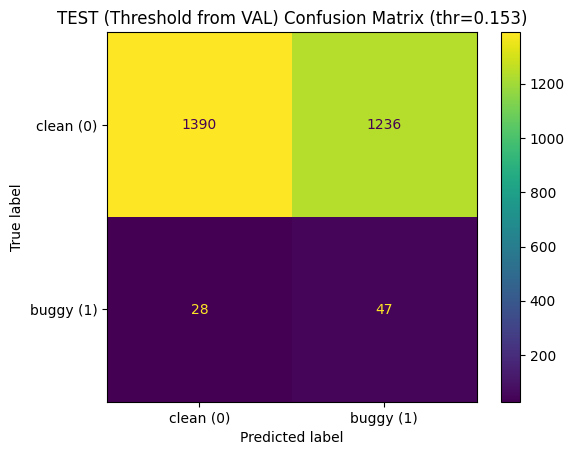

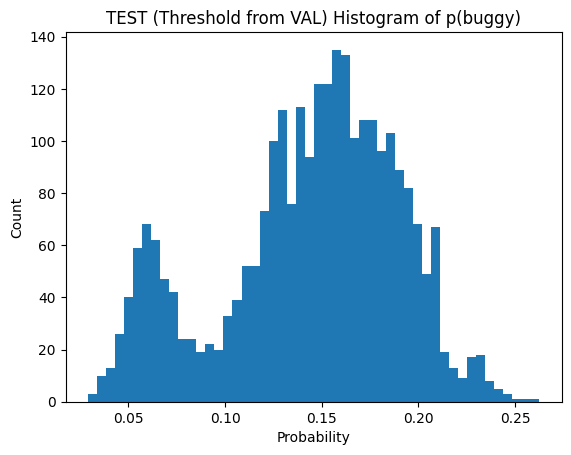

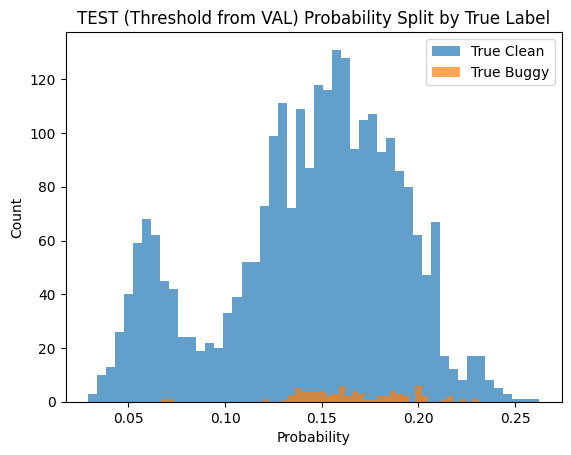

In [ ]:
# ===== Choose threshold from VALIDATION =====

y_val, p_val = collect_preds_graph(model, val_loader, device)
thr = best_threshold_by_f1(y_val, p_val)

print("Threshold selected from VAL:", round(thr, 4))


# ===== Apply threshold to TEST =====

y_test, p_test = collect_preds_graph(model, test_loader, device)

plot_confusion_and_hist(
    y_test,
    p_test,
    thr=thr,
    title_prefix="TEST (Threshold from VAL)"
)

In [ ]:
test_m = eval_gat(model, test_loader)
print("TEST:", test_m)

TEST: {'PR_AUC_AP': 0.03957746811101259, 'best_thr': 0.13448047637939453, 'accuracy': 0.3872639763050722, 'precision': 0.04123112659698026, 'recall': 0.9466666666666667, 'f1': 0.0790205898720089, 'bug_rate': 0.027767493520918177, 'N': 2701}


In [ ]:
print("\n\n===== FINAL TEST RESULTS =====")
test_metrics = eval_gat(model, test_loader)

print(f"Total lines evaluated: {test_metrics['N']}")
print(f"Bug rate: {test_metrics['bug_rate']:.4f}")
print("-" * 40)
print(f"Accuracy : {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall   : {test_metrics['recall']:.4f}")
print(f"F1 Score : {test_metrics['f1']:.4f}")
print("-" * 40)
print(f"PR-AUC   : {test_metrics['PR_AUC_AP']:.4f}")
print(f"Best threshold (F1): {test_metrics['best_thr']:.4f}")
print("=" * 50)



===== FINAL TEST RESULTS =====
Total lines evaluated: 2701
Bug rate: 0.0278
----------------------------------------
Accuracy : 0.3873
Precision: 0.0412
Recall   : 0.9467
F1 Score : 0.0790
----------------------------------------
PR-AUC   : 0.0396
Best threshold (F1): 0.1345


In [ ]:
def print_metrics(title, m):
    print(f"\n===== {title} =====")
    print(f"Lines evaluated: {m['N']}")
    print(f"Bug rate: {m['bug_rate']:.4f}")
    print(f"Accuracy : {m['accuracy']:.4f}")
    print(f"Precision: {m['precision']:.4f}")
    print(f"Recall   : {m['recall']:.4f}")
    print(f"F1 Score : {m['f1']:.4f}")
    print(f"PR-AUC   : {m['PR_AUC_AP']:.4f}")
    print(f"Best threshold: {m['best_thr']:.4f}")
    print("-" * 60)

In [ ]:
print_metrics("TRAIN", eval_gat(model, train_loader))


===== TRAIN =====
Lines evaluated: 731563
Bug rate: 0.0127
Accuracy : 0.9099
Precision: 0.0269
Recall   : 0.1727
F1 Score : 0.0465
PR-AUC   : 0.0205
Best threshold: 0.1932
------------------------------------------------------------


In [ ]:
print_metrics("VALIDATION", eval_gat(model, val_loader))
print_metrics("TEST", eval_gat(model, test_loader))


===== VALIDATION =====
Lines evaluated: 1145
Bug rate: 0.3703
Accuracy : 0.5956
Precision: 0.4680
Recall   : 0.6722
F1 Score : 0.5518
PR-AUC   : 0.4491
Best threshold: 0.1531
------------------------------------------------------------

===== TEST =====
Lines evaluated: 2701
Bug rate: 0.0278
Accuracy : 0.3873
Precision: 0.0412
Recall   : 0.9467
F1 Score : 0.0790
PR-AUC   : 0.0396
Best threshold: 0.1345
------------------------------------------------------------


In [ ]:
#Prediction+Confusion metrics+histogram

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

@torch.no_grad()
def collect_preds_graph(model, loader, device):
    model.eval()
    y_all = []
    p_all = []
    meta_all = []  # optional: window metas per batch, not per node

    for batch in loader:
        batch = batch.to(device)
        logits = model(batch)                       # [N,2]
        p_bug = torch.softmax(logits, dim=-1)[:, 1] # [N]
        y = batch.y                                 # [N]

        y_all.append(y.detach().cpu().numpy().astype(int))
        p_all.append(p_bug.detach().cpu().numpy())

        # batch.meta is a list of per-graph metas; keep if you want
        if hasattr(batch, "meta"):
            meta_all.append(batch.meta)

    y_true = np.concatenate(y_all)
    p_buggy = np.concatenate(p_all)
    return y_true, p_buggy

def best_threshold_by_f1(y_true, p_buggy):
    from sklearn.metrics import precision_recall_curve
    prec, rec, thr = precision_recall_curve(y_true, p_buggy)
    f1 = 2*prec[:-1]*rec[:-1] / (prec[:-1]+rec[:-1] + 1e-12)
    if len(f1) == 0:
        return 0.5
    return float(thr[int(np.argmax(f1))])

def plot_confusion_and_hist(y_true, p_buggy, thr=None, title_prefix=""):
    if thr is None:
        thr = best_threshold_by_f1(y_true, p_buggy)

    y_pred = (p_buggy >= thr).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["clean(0)", "buggy(1)"])
    fig = plt.figure()
    ax = plt.gca()
    disp.plot(ax=ax, values_format="d")
    ax.set_title(f"{title_prefix} Confusion Matrix (thr={thr:.2f})")
    plt.show()

    # Histogram of probabilities (overall)
    plt.figure()
    plt.hist(p_buggy, bins=50)
    plt.title(f"{title_prefix} Histogram of buggy probability")
    plt.xlabel("p(buggy)")
    plt.ylabel("count")
    plt.show()

    # Histogram split by true label
    plt.figure()
    plt.hist(p_buggy[y_true==0], bins=50, alpha=0.7, label="true clean")
    plt.hist(p_buggy[y_true==1], bins=50, alpha=0.7, label="true buggy")
    plt.title(f"{title_prefix} Histogram split by true label")
    plt.xlabel("p(buggy)")
    plt.ylabel("count")
    plt.legend()
    plt.show()

# Usage:
# y_true, p_buggy = collect_preds_graph(model, test_loader, device)
# plot_confusion_and_hist(y_true, p_buggy, title_prefix="FULL (GAT)")

In [ ]:
y_true, p_buggy = collect_preds_graph(model, test_loader, device)

In [ ]:
thr = best_threshold_by_f1(y_true, p_buggy)
print("Best threshold (by F1):", round(thr, 4))

Best threshold (by F1): 0.1345


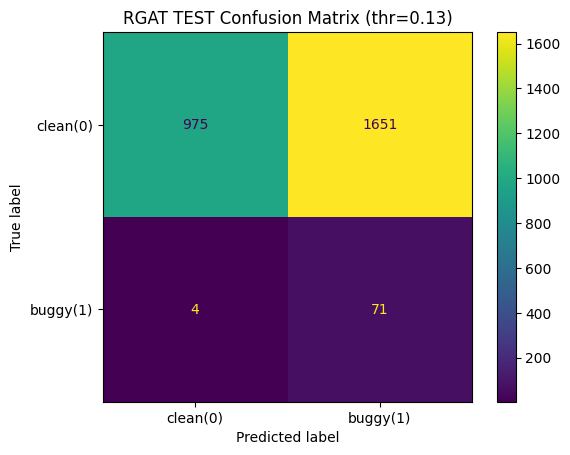

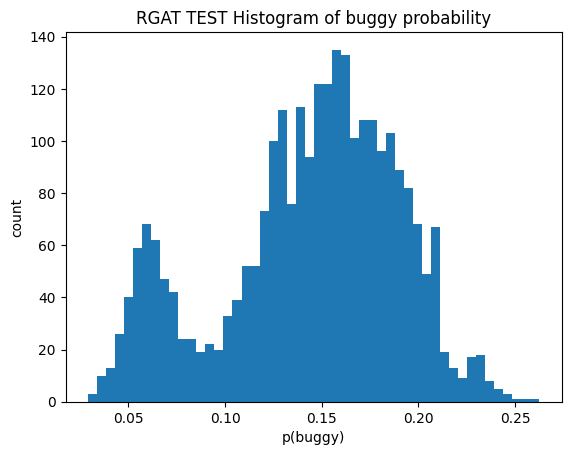

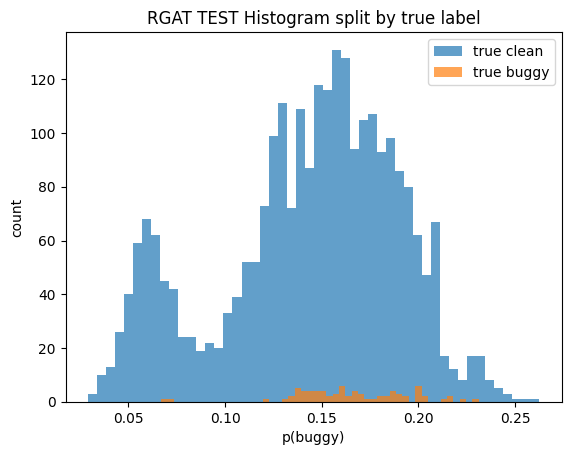

In [ ]:
plot_confusion_and_hist(y_true, p_buggy, thr=thr, title_prefix="RGAT TEST")

In [ ]:
#Predict buggy line

from torch_geometric.data import Batch

@torch.no_grad()
def predict_one_window(model, loader, device, window_index=0, topk=10):
    model.eval()

    # get a single batch, then pick the first graph inside it
    it = iter(loader)
    batch = next(it)  # gets a PyG Batch
    batch = batch.to(device)

    logits = model(batch)
    p_bug = torch.softmax(logits, dim=-1)[:, 1].detach().cpu()

    # split node probs per graph using ptr
    # batch.ptr: size (num_graphs+1), ptr[g]..ptr[g+1]-1 are nodes of graph g
    g = 0
    s = int(batch.ptr[g])
    e = int(batch.ptr[g+1])

    probs = p_bug[s:e].numpy()
    y = batch.y[s:e].detach().cpu().numpy().astype(int)

    # Safely get meta for the g-th graph by converting batch back to data_list
    data_list = batch.to_data_list()
    meta = data_list[g].meta if hasattr(data_list[g], "meta") else {}
    # Convert line_no_start to a scalar integer if it's a tensor
    line_no_start = int(meta.get("line_no_start", 1)) if torch.is_tensor(meta.get("line_no_start", 1)) else meta.get("line_no_start", 1)

    # rank top-k
    idx = np.argsort(-probs)[:topk]
    print("Meta:", meta)
    print(f"Window nodes: {e-s} | bug_rate={y.mean():.4f}")
    print("\nTop suspicious lines:")
    for j in idx:
        ln = (line_no_start + j)  # approx mapping for the window
        print(f"  line {ln:>5} | p={probs[j]:.4f} | y={y[j]}")

# Usage:
# predict_one_window(model, test_loader, device, topk=15)

In [ ]:
predict_one_window(model, test_loader, device, topk=15)

Meta: {'commit': '117891878e5be4d6b771ae5de299e51b679cea27', 'filepath': 'src\\blib2to3\\pgen2\\driver.py', 'start': tensor([0], device='cuda:0'), 'end': tensor([256], device='cuda:0'), 'L': tensor([256], device='cuda:0'), 'line_no_start': tensor([1], device='cuda:0')}
Window nodes: 256 | bug_rate=0.0391

Top suspicious lines:
  line   255 | p=0.2296 | y=0
  line   256 | p=0.2214 | y=0
  line    80 | p=0.2106 | y=0
  line   147 | p=0.2104 | y=0
  line   188 | p=0.2091 | y=0
  line   169 | p=0.2072 | y=0
  line   224 | p=0.2068 | y=0
  line   172 | p=0.2068 | y=0
  line    44 | p=0.2041 | y=1
  line   176 | p=0.2041 | y=0
  line   186 | p=0.2030 | y=0
  line   137 | p=0.2028 | y=0
  line   194 | p=0.2018 | y=0
  line   247 | p=0.1993 | y=0
  line   152 | p=0.1991 | y=0


In [ ]:
for i in range(3):  # show first 3 windows
    print("\n==============================")
    print(f"WINDOW {i}")
    print("==============================")
    predict_one_window(model, test_loader, device, topk=10)


WINDOW 0
Meta: {'commit': '117891878e5be4d6b771ae5de299e51b679cea27', 'filepath': 'src\\blib2to3\\pgen2\\driver.py', 'start': tensor([0], device='cuda:0'), 'end': tensor([256], device='cuda:0'), 'L': tensor([256], device='cuda:0'), 'line_no_start': tensor([1], device='cuda:0')}
Window nodes: 256 | bug_rate=0.0391

Top suspicious lines:
  line   188 | p=0.1829 | y=0
  line   174 | p=0.1818 | y=1
  line   256 | p=0.1804 | y=0
  line   210 | p=0.1789 | y=0
  line   164 | p=0.1777 | y=0
  line   224 | p=0.1764 | y=0
  line    44 | p=0.1758 | y=1
  line   255 | p=0.1754 | y=0
  line   163 | p=0.1751 | y=0
  line   169 | p=0.1746 | y=0

WINDOW 1
Meta: {'commit': '117891878e5be4d6b771ae5de299e51b679cea27', 'filepath': 'src\\blib2to3\\pgen2\\driver.py', 'start': tensor([0], device='cuda:0'), 'end': tensor([256], device='cuda:0'), 'L': tensor([256], device='cuda:0'), 'line_no_start': tensor([1], device='cuda:0')}
Window nodes: 256 | bug_rate=0.0391

Top suspicious lines:
  line   188 | p=0.182

In [ ]:
#Attention heat map

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGATConv

class LineRGATWithAttn(nn.Module):
    def __init__(self, in_dim=512, hid=128, num_relations=3, heads=4, dropout=0.2):
        super().__init__()
        self.rgat1 = RGATConv(in_dim, hid, num_relations=num_relations, heads=heads, dropout=dropout)
        self.rgat2 = RGATConv(hid*heads, hid, num_relations=num_relations, heads=1, dropout=dropout)
        self.cls = nn.Linear(hid, 2)

    def forward(self, data, return_attn=False):
        x, edge_index, edge_type = data.x, data.edge_index, data.edge_type

        if return_attn:
            # Many PyG builds support this; if yours doesn't, the try/except will catch it.
            try:
                x1, (ei1, alpha1) = self.rgat1(x, edge_index, edge_type, return_attention_weights=True)
            except TypeError:
                # fallback if signature differs
                x1, (ei1, alpha1) = self.rgat1(x, edge_index, edge_type, return_attention_weights=True)
            x1 = F.elu(x1)
        else:
            x1 = F.elu(self.rgat1(x, edge_index, edge_type))

        x2 = F.elu(self.rgat2(x1, edge_index, edge_type))
        logits = self.cls(x2)

        if return_attn:
            return logits, (ei1, alpha1)
        return logits

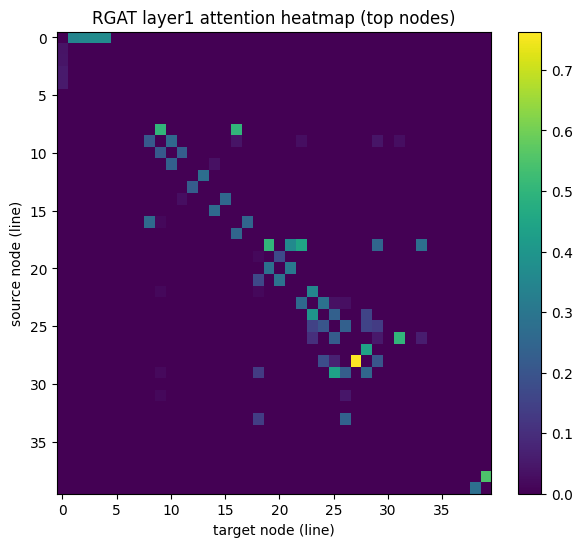

In [ ]:
import matplotlib.pyplot as plt

# Instantiate the attention-enabled model with the same parameters
model_attn = LineRGATWithAttn(in_dim=512, hid=128, num_relations=3, heads=4, dropout=0.2).to(device);

# Load the trained weights from the original model
model_attn.load_state_dict(model.state_dict());

# Plot the attention heatmap using the test_loader
plot_rgat_attention_heatmap(model_attn, test_loader, device);

In [ ]:
#plot attention heat map

import numpy as np
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_rgat_attention_heatmap(model_attn, loader, device, topk_nodes=40):
    model_attn.eval()
    batch = next(iter(loader)).to(device)

    # forward with attention
    logits, (ei, alpha) = model_attn(batch, return_attn=True)

    # alpha could be [E, heads] or [E, heads, ...] depending on PyG build
    alpha = alpha.detach().cpu()
    if alpha.dim() >= 2:
        att = alpha.mean(dim=1).numpy()   # average over heads
    else:
        att = alpha.numpy()

    # pick first graph in batch
    g = 0
    s = int(batch.ptr[g]); e = int(batch.ptr[g+1])
    L = e - s

    # probs for top-k node selection
    p_bug = torch.softmax(logits, dim=-1)[:, 1].detach().cpu().numpy()
    probs = p_bug[s:e]

    # restrict edges to nodes in this graph
    ei_cpu = ei.detach().cpu()
    mask_edges = (ei_cpu[0] >= s) & (ei_cpu[0] < e) & (ei_cpu[1] >= s) & (ei_cpu[1] < e)
    ei_g = ei_cpu[:, mask_edges] - s
    att_g = att[mask_edges.numpy()]

    # choose nodes to display
    if topk_nodes is not None and L > topk_nodes:
        nodes = np.argsort(-probs)[:topk_nodes]
        nodes = np.sort(nodes)
    else:
        nodes = np.arange(L)

    node_to_small = {int(n): i for i, n in enumerate(nodes)}
    M = np.zeros((len(nodes), len(nodes)), dtype=np.float32)

    # fill matrix: source -> target
    for k in range(ei_g.size(1)):
        u = int(ei_g[0, k]); v = int(ei_g[1, k])
        if u in node_to_small and v in node_to_small:
            M[node_to_small[u], node_to_small[v]] += float(att_g[k])

    plt.figure(figsize=(7, 6))
    plt.imshow(M, aspect="auto")
    plt.title("RGAT layer1 attention heatmap (top nodes)")
    plt.xlabel("target node (line)")
    plt.ylabel("source node (line)")
    plt.colorbar()
    plt.show()

In [ ]:
import torch

def count_buggy_lines(loader):
    total_lines = 0
    total_buggy = 0

    for batch in loader:
        y = batch.y  # shape [N]
        total_lines += y.numel()
        total_buggy += int((y == 1).sum().item())

    bug_rate = total_buggy / total_lines if total_lines > 0 else 0.0

    print("===== TEST SPLIT STATISTICS =====")
    print(f"Total lines : {total_lines}")
    print(f"Buggy lines : {total_buggy}")
    print(f"Clean lines : {total_lines - total_buggy}")
    print(f"Bug rate    : {bug_rate:.4f} ({bug_rate*100:.2f}%)")
    print("=================================")

    return total_lines, total_buggy, bug_rate

# Run it
count_buggy_lines(test_loader)

===== TEST SPLIT STATISTICS =====
Total lines : 2701
Buggy lines : 75
Clean lines : 2626
Bug rate    : 0.0278 (2.78%)


(2701, 75, 0.027767493520918177)

(array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 2., 3.,
        2., 2., 2., 0., 0., 1., 0., 0., 1., 0., 2., 2., 0., 1., 0., 2., 0.,
        1., 3., 1., 1., 1., 0., 1., 2., 0., 0., 4., 3., 4., 0., 2., 0., 0.,
        1., 2., 2., 2., 1., 1., 1., 0., 1., 0., 1., 3., 2., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 1., 2., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]),
 array([0.14230847, 0.14275953, 0.14321057, 0.14366163, 0.14411268,
        0.14456373, 0.14501478, 0.14546584, 0.14591689, 0.14636794,
        0.146819  , 0.14727004, 0.1477211 , 0.14817214, 0.1486232 ,
        0.14907426, 0.1495253 , 0.14997636, 0.1504274 , 0.15087846,
        0.1513295 , 0.15178056, 0.15223162, 0.15268266, 0.15313372,
        0.15358476, 0.15403582, 0.15448686, 0.15493792, 0.15538898,
        0.15584002, 0.15629108, 0.15674213, 0.15719318, 0.15764423,
        0.15809529, 0.15854633, 0.15899739, 0.15944844, 0.15989949,
      

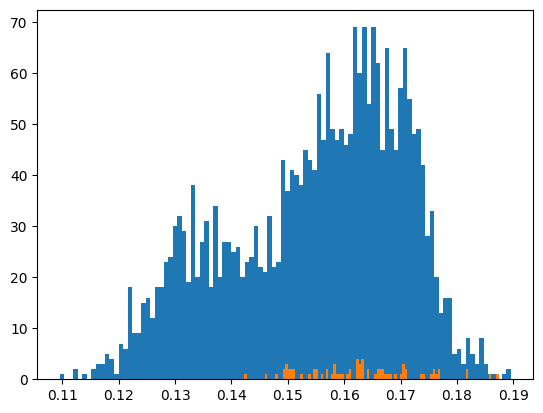

In [ ]:
plt.hist(p_buggy[y_true==0], bins=100)
plt.hist(p_buggy[y_true==1], bins=100)

In [ ]:
def compute_bug_stats(loader, name="SPLIT"):
    total_lines = 0
    total_buggy = 0

    for batch in loader:
        y = batch.y
        total_lines += y.numel()
        total_buggy += int((y == 1).sum().item())

    bug_rate = total_buggy / total_lines if total_lines > 0 else 0.0

    print(f"===== {name} =====")
    print(f"Total lines : {total_lines}")
    print(f"Buggy lines : {total_buggy}")
    print(f"Clean lines : {total_lines - total_buggy}")
    print(f"Bug rate    : {bug_rate:.4f} ({bug_rate*100:.2f}%)")
    print("-"*50)

    return total_lines, total_buggy, bug_rate


# Run for all splits
compute_bug_stats(train_loader, "TRAIN")
compute_bug_stats(val_loader,   "VALIDATION")
compute_bug_stats(test_loader,  "TEST")

===== TRAIN =====
Total lines : 731563
Buggy lines : 9299
Clean lines : 722264
Bug rate    : 0.0127 (1.27%)
--------------------------------------------------
===== VALIDATION =====
Total lines : 1145
Buggy lines : 424
Clean lines : 721
Bug rate    : 0.3703 (37.03%)
--------------------------------------------------
===== TEST =====
Total lines : 2701
Buggy lines : 75
Clean lines : 2626
Bug rate    : 0.0278 (2.78%)
--------------------------------------------------


(2701, 75, 0.027767493520918177)

# GAT fusion and dual-head model

Edge-type embeddings: Inject coarse edge-type info into GAT via an augmentation trick.

Residuals and normalization: Keep features stable and avoid over-smoothing.

Heads:

Line-level sigmoid for per-line probabilities
File-level attention pooling + MLP for buggy vs clean